In [138]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import f1_score

# NOT SURE WHAT THE POINT OF THE CODE BELOW IS, REMOVE IF NOT NEEDED

#if torch.cuda.is_available():
#    torch.backends.cuda.deterministic = True

In [35]:
# For Mitch's error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load and Prepare Data

In [105]:
# # get data matrices and labels
# train_data = np.load('../process/project_data/x_train_v1.npy')
# read_train_labels = pd.read_csv('../process/project_data/y_train_v1.csv')
# train_labels = read_train_labels['Label'] == 'Anomaly'
# train_labels = train_labels.astype(int) # may not make sense to have an an int
# test_data = np.load('../process/project_data/x_test_v1.npy')
# read_test_labels = pd.read_csv('../process/project_data/y_test_v1.csv')
# test_labels = read_test_labels['Label'] == 'Anomaly'
# test_labels = test_labels.astype(int)


data_loc = "../../project_processed_data/"

# Train sets
train_data = np.load('{}x_train_tf-idf_rolling_v2.npy'.format(data_loc))
read_train_labels = pd.read_csv('{}y_train_tf-idf_rolling_v2.csv'.format(data_loc))
train_labels = read_train_labels['Label'] == 'Anomaly'
train_labels = train_labels.astype(int) # may not make sense to have an an int

# Test sets
test_data = np.load('{}x_val_tf-idf_rolling_v2.npy'.format(data_loc))
read_test_labels = pd.read_csv('{}y_val_tf-idf_rolling_v2.csv'.format(data_loc))
test_labels = read_test_labels['Label'] == 'Anomaly'
test_labels = test_labels.astype(int)

# data_dims = (19, 48)

In [108]:
# Giving strange idx errors 

# # Create val set
# random.seed(10)

# val_percent_size = 0.10
# val_size = int(train_data.shape[0] * val_percent_size)
# val_idx = random.sample(range(0, train_data.shape[0]), val_size)

# # select the val sets based on random indexing
# val_data = np.take(train_data, val_idx, axis=0)
# val_labels = train_labels.iloc[val_idx]

# # delete the val indexes from the train data
# train_data = np.delete(train_data, val_idx, axis=0)
# train_labels = train_labels.drop(train_labels.index[[val_idx]])

# Train sets
val_data = np.load('{}x_val_tf-idf_rolling_v2.npy'.format(data_loc))
read_val_labels = pd.read_csv('{}y_train_tf-idf_rolling_v2.csv'.format(data_loc))
val_labels = read_val_labels['Label'] == 'Anomaly'
val_labels = val_labels.astype(int) # may not make sense to have an an int

In [109]:
# for testing on a subset
train_data = train_data[0:10000]
test_data = test_data[0:10000]
val_data = val_data[0:10000]
val_labels = val_labels[0:10000]
train_labels = train_labels[0:10000]
test_labels = test_labels[0:10000]

In [110]:
data_dims = (train_data[1], train_data[2])
print(train_data.shape)

(10000, 19, 46)


In [111]:
class logDataset(Dataset):
    """Log Anomaly Features Dataset"""
    
    def __init__(self, data_vec, labels=None):
        self.X = data_vec
        self.y = labels
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        data_matrix = self.X[idx]
        
        if not self.y is None:
            return(data_matrix, self.y[idx])
        else:
            return data_matrix


In [112]:
# THIS TRANSFORM CLASS DIDN"T WORK, LEFT THIS IN JUST AS A REMINDER TO CONSIDER NORMALIZATION
# AS WeLL AS THE COMMENT BELOW

# NOTE THAT AS WE'VE DONE TF-IDF, WE MAY NOT WANT TO NORMALIZE
# HOWEVER, ONE OF THE ODD THINGS HERE IS THAT SINCE WE'RE PASSING FILTERS OVER THINGS
# IF THE COLUMNS REPRESENT SLIGHTLY DIFFERENT THINGS IT MAY BE AN ISSUE, ESPECIALLY FOR POOLING?
# NORMALLY EACH PIXEL REPRESENTS THE EXACT SAME THING, NOT SURE IF THAT'S STILL THE CASE AFTER
# TF-IDF

# define transforms
#train_mean = (0.5, 0.5, 0.5)
#train_std = (0.5, 0.5, 0.5)

#apply_transforms = transforms.Compose([#transforms.Resize((32, 32)), # probably not using this
#                                        transforms.ToPILImage(), # believe this is required
#                                        transforms.ToTensor(),
#                                        #transforms.Normalize(train_mean, train_std),
#                                        transforms.Pad((0, 0, 0, 1))]) # not sure if this is quite correct


In [113]:
# Convert to tensort and pad matrixes to have dims of 20x48 instead of 19x48
# Also need to add a dimension for conv2D
train_data = torch.tensor(train_data, dtype=torch.float32)
train_data = F.pad(input=train_data, pad=(0, 0, 0, 1), mode='constant', value=0) # pad the bottom with 0s
train_data = np.expand_dims(train_data, axis=1)
test_data = torch.tensor(test_data, dtype=torch.float32)
test_data = F.pad(input=test_data, pad=(0, 0, 0, 1), mode='constant', value=0)
test_data = np.expand_dims(test_data, axis=1)
val_data = torch.tensor(val_data, dtype=torch.float32)
val_data = F.pad(input=val_data, pad=(0, 0, 0, 1), mode='constant', value=0)
val_data = np.expand_dims(val_data, axis=1)

In [114]:
train_data.shape

(10000, 1, 20, 46)

In [115]:
val_data.shape

(10000, 1, 20, 46)

In [116]:
# Hyperparameters
RANDOM_SEED = 1
# THESE ARE ALL STARTING POINTS BASED ON LAB3
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
# NUM_FEATURES = data_dims[0] * data_dims[1] # not sure this is needed currently

# not sure we should be using an architecture with 2 classes with softmax
# doesn't it make more sense to have a single output node
# previous labs/lectures have 2 classes with softmax which is somewhat confusing
NUM_CLASSES = 2

# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"


In [117]:
# pass datasets into the custom dataclass
train_dataset = logDataset(train_data, labels = train_labels)
test_dataset = logDataset(test_data, labels = test_labels)
val_dataset = logDataset(val_data, labels = val_labels)

In [118]:
# just a check that it worked
# train_dataset.__getitem__(3)

In [121]:
# use DataLoader class
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=0, # couldn't use workers https://github.com/fastai/fastbook/issues/85
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

val_loader = DataLoader(dataset=val_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)


# Checking the dataset
for data, labels in train_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

# Checking the dataset
for data, labels in test_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break
    
# Checking the dataset
for data, labels in val_loader:  
    print('Matrix batch dimensions:', data.shape)
    print('Matrix label dimensions:', labels.shape)
    break

Matrix batch dimensions: torch.Size([128, 1, 20, 46])
Matrix label dimensions: torch.Size([128])
Matrix batch dimensions: torch.Size([128, 1, 20, 46])
Matrix label dimensions: torch.Size([128])
Matrix batch dimensions: torch.Size([128, 1, 20, 46])
Matrix label dimensions: torch.Size([128])


## Setup Model

In [122]:
# this is something to do with warming up the nn
# NEED TO FIGURE THIS OUT AND KEEP OR REMOVE
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(val_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [171]:
##########################
### MODEL
##########################


class logCNN(nn.Module):

    def __init__(self, num_classes):
        super(logCNN, self).__init__()
        # noticed that in many of the example models we're initializing weights and biases but
        # not in the CNN example, check into this
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # Selection of 16 and 32 based on discussion with Debangsha, use for now
            # will need to figure out kernel size that works for dims and potentially add pooling
            # need to figure out how to deal with non-square image
            # goes in as 20x48
            nn.Conv2d(1, 16, kernel_size=2),
            # comes out as 19x47
            nn.ReLU(),
            #F.pad(pad=(0, 1, 0, 1), mode='constant', value=0), # may need to use this (won't work in sequential)
            nn.MaxPool2d(kernel_size=2),
            # comes out as ???
            nn.Conv2d(16, 32, kernel_size=2), # can also add padding directly into here (but is equal on either side) - (1, 2) 1 on left and right and 2 each above and below
            nn.ReLU(),
            #F.pad(pad=(0, 1, 0, 1), mode='constant', value=0), # may need to use this (won't work in sequential)
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            # NEED TO FIGURE OUT THE SIZE OF THE IMAGE
            nn.Linear(1280, 120), # NEED TO DECIDE ON NUMBER OF NODES (120 BASED ON LAB3) ## NB changed to 1280 from 1408 based on error
            nn.ReLU(),
            nn.Linear(120, 84), # NEED TO DECIDE ON NUMBER OF NODES (84 BASED ON LAB3)
            nn.ReLU(),
            nn.Linear(84, num_classes), # NOT SURE WE WANT TO BE USING 2 NODE OUTPUT
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
#         print(x.shape) # Was printing in the training logging
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1) # NOT SURE WE NEED SOFTMAX, POTENTIALLY SIGMOID?
        return logits, probas


## NOTE: WE MAY WANT TO CONSIDER USING DROPOUT AND L2 PENALTY; SEE LETURE 4 EXAMPLES FOR THIS
## RELATIVELY EASY TO IMPLEMENT BUT MAY WANT TO CONSIDER ADDING VALIDATION SET SPLIT FROM THE TRAINING SET
## WHEN DOING THIS AND PLOTTING THE VALIDATION/TRAINING COST FUNCTIONS

In [172]:
torch.manual_seed(RANDOM_SEED)

model = logCNN(NUM_CLASSES) # THIS WILL BE UPDATED IF NOT USING 2 OUTPUT NODES
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train Model

In [174]:
# NEED TO FIGURE OUT THE BEST FUNCTION FOR ACCURACY
# NEED TO FOCUS ON TRUE/FALSE, NOT ON CLASSES
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        
        # NOTE TO SELF WHEN CHANGING INT TARGETS AT TOP OF NOTEBOOK, WILL ALSO HAVE TO CHANGE / REMOVE .long here
        targets = targets.to(DEVICE, dtype=torch.long) # had to pass in to torch.long based on the 1, 0 int labels

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def compute_f1(model, data_loader, device):
    y_hats = []
    y_acts = []
    for i, (inputs, targets) in enumerate(data_loader):
        yhat = model(inputs)[-1].cpu().detach().numpy().round()
        yhat = np.argmax(yhat, axis=1)
        y_hats.append(yhat)
        y_acts.append(list(targets.cpu().detach().numpy()))
    
    y_hats = [item for sublist in y_hats for item in sublist]
    y_acts = [item for sublist in y_acts for item in sublist]
    return f1_score(y_acts, y_hats)

  

start_time = time.time()
minibatch_cost = [] # this isn't in the CNN model example but is from lecture 3 example files
epoch_train_performance = []
epoch_val_performance = []
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE, dtype=torch.long) # another had to use torch.long
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets) # NEED TO MODIFY BASED ON BEST COST FUNCTION
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost) # from lecture 3 example files
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING - MAY WANT TO MODIFY LOGGING INTERVALS
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost, ))

        
    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        train_performance = compute_f1(model, train_loader, device=DEVICE)
        val_performance = compute_f1(model, val_loader, device=DEVICE)
        epoch_train_performance.append(train_performance) # from lecture 3 example files
        epoch_val_performance.append(val_performance)
        print('Epoch: %03d/%03d | Train: %.3f%%   | Val: %.3f%%' % (
              epoch+1, NUM_EPOCHS, train_performance, val_performance))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0079 | Cost: 0.0002
Epoch: 001/010 | Batch 0050/0079 | Cost: 0.0008
Epoch: 001/010 | Train: 0.992%   | Val: 0.051%
Time elapsed: 0.07 min
Epoch: 002/010 | Batch 0000/0079 | Cost: 0.0001
Epoch: 002/010 | Batch 0050/0079 | Cost: 0.0169
Epoch: 002/010 | Train: 0.993%   | Val: 0.051%
Time elapsed: 0.13 min
Epoch: 003/010 | Batch 0000/0079 | Cost: 0.0230
Epoch: 003/010 | Batch 0050/0079 | Cost: 0.0002
Epoch: 003/010 | Train: 0.994%   | Val: 0.051%
Time elapsed: 0.20 min
Epoch: 004/010 | Batch 0000/0079 | Cost: 0.0000
Epoch: 004/010 | Batch 0050/0079 | Cost: 0.0001
Epoch: 004/010 | Train: 0.993%   | Val: 0.052%
Time elapsed: 0.27 min
Epoch: 005/010 | Batch 0000/0079 | Cost: 0.0001
Epoch: 005/010 | Batch 0050/0079 | Cost: 0.0000
Epoch: 005/010 | Train: 0.993%   | Val: 0.052%
Time elapsed: 0.34 min
Epoch: 006/010 | Batch 0000/0079 | Cost: 0.0070
Epoch: 006/010 | Batch 0050/0079 | Cost: 0.0000
Epoch: 006/010 | Train: 0.993%   | Val: 0.050%
Time elapsed: 0.40 min
Epoc

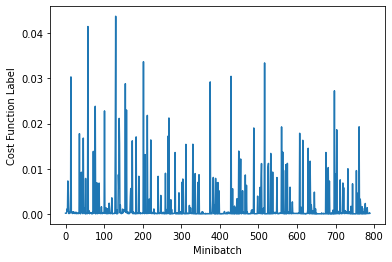

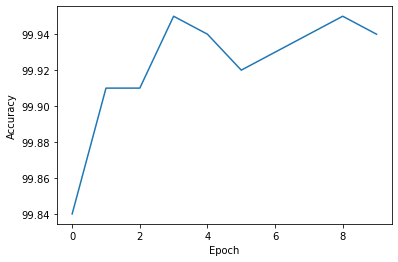

In [175]:
# plot cost functions
minibatch_cost_cpu = [i.cpu().detach().numpy() for i in minibatch_cost]
epoch_cost_cpu = [i.cpu().detach().numpy() for i in epoch_performance]

plt.plot(range(len(minibatch_cost_cpu)), minibatch_cost_cpu)
plt.ylabel('Cost Function Label') # update this label after cost function selected
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost_cpu)), epoch_cost_cpu)
plt.ylabel('Accuracy') # update this label after cost function selected
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [153]:
with torch.set_grad_enabled(False): # save memory during inference
    # THIS NEEDS TO BE UPDATED BASED ON THE FUNCTION NAME WE'RE USING
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 93.08%


In [154]:
with torch.set_grad_enabled(False): # save memory during inference
    # THIS NEEDS TO BE UPDATED BASED ON THE FUNCTION NAME WE'RE USING
    print('Train accuracy: %.2f%%' % (compute_accuracy(model, train_loader, device=DEVICE)))

Train accuracy: 99.94%


In [155]:
# WE NEED TO BE EXTENDING THE PERFORMANCE MEASURES TO INCLUDE THOSE USED IN THE PAPERS
# F SCORE, PRECISION ETC ETC, MOST OF THE PAPERS SEEM TO USE SIMILAR METRICS, SHOULD BE RELATIVELY SIMPLE
# AND COULD BE POTENTIALLY BUILD DIRECTLY INTO THE COST FUNCTION (THE FUNCTION COULD RETURN MULTIPLE PARAMS AND WE WOULD OBVIOUSLY JUST USE THE ONE WE NEEDED FOR MODEL TRAINING BUT THEN WE WOULD HAVE ACCESS TO ALL OF THEM INSTEAD OF WRITING ANOTHER FUNCTION)

In [156]:
# ALSO RECOMMEND SOME SORT OF VIS TOOL ON BEING ABLE TO LOOK AT A COUPLE OF THE TIME IMAGES THAT ARE LABELLED ANOMALOUS CORRECTLY AND ONES THAT ARE LABELLED ANOMLAOUS INCORRECTLY OR NORMAL INCORRECTLY

In [163]:
# Evaluate F1 score on test set
y_hats = []
y_acts = []
counter = 0
for i, (inputs, targets) in enumerate(val_loader):
    yhat = model(inputs)[-1].cpu().detach().numpy().round()
    yhat = np.argmax(yhat, axis=1)
    y_hats.append(yhat)
    y_acts.append(list(targets.cpu().detach().numpy()))
    counter += 1

y_hats = [item for sublist in y_hats for item in sublist]
y_acts = [item for sublist in y_acts for item in sublist]

f1 = f1_score(y_acts, y_hats)
print(f1)


0.051513200257566


In [164]:
# Evaluate F1 score on test set
y_hats = []
y_acts = []
counter = 0
for i, (inputs, targets) in enumerate(test_loader):
    yhat = model(inputs)[-1].cpu().detach().numpy().round()
    yhat = np.argmax(yhat, axis=1)
    y_hats.append(yhat)
    y_acts.append(list(targets.cpu().detach().numpy()))
    counter += 1

y_hats = [item for sublist in y_hats for item in sublist]
y_acts = [item for sublist in y_acts for item in sublist]

f1 = f1_score(y_acts, y_hats)
print(f1)

0.4594410361281527
